In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

import pyspark as ps

In [107]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('constructionPermitsAustin')
         .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
sc

<SparkContext master=local[4] appName=constructionPermitsAustin>

In [4]:
permits_all = spark.read.csv('../data/Issued_Construction_Permits.csv',
                    header=True,
                    sep=",",
                    inferSchema=True)

# permits_all.printSchema()

# print(f'line count: {permits_all.count()}')

# permits_all.show()

In [5]:
permits_all.createOrReplaceTempView('permits')

In [6]:
permits_2019 = spark.sql('SELECT * from permits WHERE `Calendar Year Issued` = 2019')

In [7]:
permits_2020 = spark.sql('SELECT * from permits WHERE `Calendar Year Issued` = 2020')

In [8]:
permits_2020_df = permits_2020.toPandas()

In [9]:
# permits_2020_df.info()

In [10]:
# permits_2020_df['Location'].value_counts()

In [11]:
permits_2020_df_cleaned = permits_2020_df.drop(columns=['Project Name',
                                                        'TCAD ID',
                                                        'Property Legal Description',
                                                        'Issued In Last 30 Days',
                                                        'Issuance Method',
                                                        'Original Address 1',
                                                        'Original City',
                                                        'Original State',
                                                        'Jurisdiction',
                                                        'Link',
                                                        'Project ID',
                                                        'Master Permit Num',
                                                        'Location',
                                                        'Contractor Phone',
                                                        'Contractor Phone',
                                                        'Contractor Phone',
                                                        'Contractor Address 1',
                                                        'Contractor Address 2',
                                                        'Contractor City',
                                                        'Contractor Zip',
                                                        'Applicant Phone',
                                                        'Applicant Address 1',
                                                        'Applicant Address 2',
                                                        'Applicant City',
                                                        'Applicant Zip',
                                                        'Total Lot SQFT'])

# permits_2020_pd_cleaned

In [12]:
permits_2020_df_cleaned['Applied Date'] = pd.to_datetime(permits_2020_df_cleaned['Applied Date'])
permits_2020_df_cleaned['Issued Date'] = pd.to_datetime(permits_2020_df_cleaned['Issued Date'])
permits_2020_df_cleaned['Status Date'] = pd.to_datetime(permits_2020_df_cleaned['Status Date'])
permits_2020_df_cleaned['Expires Date'] = pd.to_datetime(permits_2020_df_cleaned['Expires Date'])
permits_2020_df_cleaned['Completed Date'] = pd.to_datetime(permits_2020_df_cleaned['Completed Date'])

In [13]:
permits_2020_df_cleaned.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69317 entries, 0 to 69316
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Permit Type                   69317 non-null  object        
 1   Permit Type Desc              69317 non-null  object        
 2   Permit Num                    69317 non-null  object        
 3   Permit Class Mapped           69317 non-null  object        
 4   Permit Class                  69317 non-null  object        
 5   Work Class                    69317 non-null  object        
 6   Condominium                   53516 non-null  object        
 7   Description                   69317 non-null  object        
 8   Applied Date                  69314 non-null  datetime64[ns]
 9   Issued Date                   69317 non-null  datetime64[ns]
 10  Day Issued                    69317 non-null  object        
 11  Calendar Year Issued        

In [14]:
permit_year = spark.sql('''SELECT `Calendar Year Issued`, COUNT(*)
                        from permits 
                        WHERE `Calendar Year Issued` > 1990 AND `Calendar Year Issued` < 2021
                        GROUP BY `Calendar Year Issued`
                        ORDER BY 1''')

<AxesSubplot:>

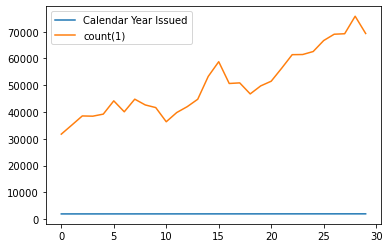

In [15]:
permit_year_df = permit_year.toPandas()
permit_year_df.plot()

In [16]:
permit_date = spark.sql('''SELECT `Applied Date`,`Issued Date`
                        from permits 
                        ORDER BY 2''')

In [17]:
permit_date_df = permit_date.toPandas().dropna()

In [18]:
permit_date_df['Applied Date'] = pd.to_datetime(permit_date_df['Applied Date'])
permit_date_df['Issued Date'] = pd.to_datetime(permit_date_df['Issued Date'])
permit_date_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038829 entries, 0 to 2038852
Data columns (total 2 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Applied Date  datetime64[ns]
 1   Issued Date   datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 46.7 MB


In [19]:
import datetime
permit_date_df_after_1990 = permit_date_df[permit_date_df['Applied Date'] >= datetime.datetime(1990,1,1)]
permit_date_df_after_1990;

In [20]:
permit_by_month = permit_date_df_after_1990.groupby(permit_date_df_after_1990['Applied Date'].dt.to_period("M")).agg('count')
permit_by_month.index = permit_by_month.index.astype('datetime64[ns]')
permit_by_month['# of Applications'] = permit_by_month['Applied Date']
permit_by_month = permit_by_month.drop(['Applied Date'], axis=1)
permit_by_month = permit_by_month.drop(['Issued Date'], axis=1)
permit_by_month;

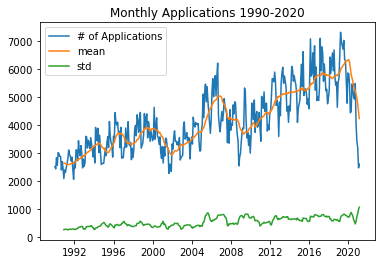

In [21]:
fig, ax = plt.subplots()
ax.plot(permit_by_month, label="# of Applications")
ax.plot(permit_by_month.rolling(window=12).mean(), label="mean")
ax.plot(permit_by_month.rolling(window=12).std(), label="std")
ax.legend()
ax.set_title("Monthly Applications 1990-2020");

In [22]:
pending_time = (permit_date_df_after_1990['Issued Date'] - permit_date_df_after_1990['Applied Date'])

In [23]:
pending_time = pending_time.dt.days.astype('int16')

In [24]:
pending_time_slice = pending_time[(pending_time <= 50) & (pending_time > 0)]

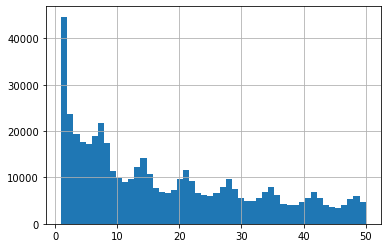

In [25]:
pending_time_slice.hist(bins=50);

In [26]:
permit_by_month_2010_2020 = permit_by_month[
    (permit_by_month.index  >= datetime.datetime(2010,1,1)) &
    (permit_by_month.index  < datetime.datetime(2020,1,1))]
permit_by_month_2010_2020;

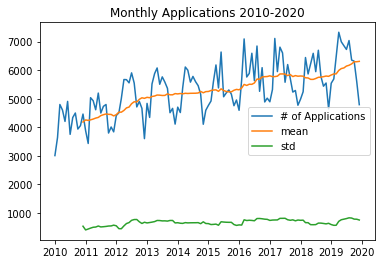

In [27]:
fig, ax = plt.subplots()
ax.plot(permit_by_month_2010_2020, label="# of Applications")
ax.plot(permit_by_month_2010_2020.rolling(window=12).mean(), label="mean")
ax.plot(permit_by_month_2010_2020.rolling(window=12).std(), label="std")
ax.legend()
ax.set_title("Monthly Applications 2010-2020");

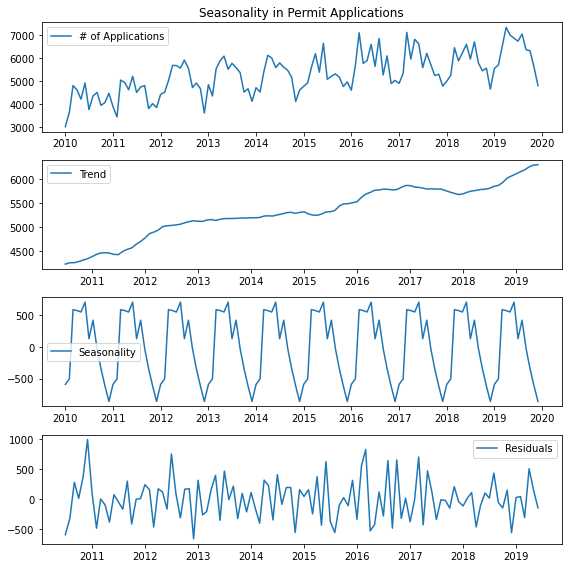

In [31]:
decomposition = seasonal_decompose(permit_by_month_2010_2020, period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(4, 1, figsize=(8, 8))

ax[0].plot(permit_by_month_2010_2020, label='# of Applications')
ax[0].legend()
ax[1].plot(trend, label='Trend')
ax[1].legend()
ax[2].plot(seasonal, label='Seasonality')
ax[2].legend()
ax[3].plot(residual, label='Residuals')
ax[3].legend()

ax[0].set_title("Seasonality in Permit Applications")

plt.tight_layout()
seasonal[:12];

In [32]:
permit_type = spark.sql('''SELECT
                        `Permit Type`,
                        COUNT(*) as `Permit Count`
                        from permits
                        GROUP BY `Permit Type`
                        ORDER BY 2 DESC''')
permit_type_df = permit_type.toPandas()
permit_type_df;

In [33]:
permit_type_desc = spark.sql('''SELECT
                            `Permit Type Desc`,
                            COUNT(*) as `Permit Count`
                            from permits
                            GROUP BY `Permit Type Desc`
                            ORDER BY 2 DESC''')
permit_type_desc_df = permit_type_desc.toPandas()
permit_type_desc_df;

In [34]:
permit_class_mapped = spark.sql('''SELECT
                                `Permit Class Mapped`,
                                COUNT(*) as `Permit Count`
                                from permits
                                GROUP BY `Permit Class Mapped`''')
permit_class_mapped_df = permit_class_mapped.toPandas()
permit_class_mapped_df;

In [35]:
permit_class = spark.sql('''SELECT
                            `Permit Class`,
                            COUNT(*) as `Permit Count`
                            from permits
                            GROUP BY `Permit Class`
                            ORDER BY 2 DESC''')
permit_class_df = permit_class.toPandas()
permit_class_df;

In [36]:
work_class = spark.sql('''SELECT
                            `Work Class`,
                            COUNT(*) as `Permit Count`
                            from permits
                            GROUP BY `Work Class`
                            ORDER BY 2 DESC''')
work_class_df = work_class.toPandas()
work_class_df;

In [37]:
description = spark.sql('''SELECT
                            `Description`,
                            COUNT(*) as `Permit Count`
                            from permits
                            GROUP BY `Description`
                            ORDER BY 2 DESC''')
description_df = description.toPandas()
description_df;

In [38]:
description_df[:20];

In [39]:
import string
from string import punctuation
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stopwords = ENGLISH_STOP_WORDS

In [82]:
description_df_cleaned = description_df.copy()
description_df_cleaned = description_df_cleaned[description_df_cleaned["Description"].notna()]
description_df_cleaned["Description"] = description_df_cleaned["Description"].str.lower()

description_df_cleaned["Description"] = description_df_cleaned["Description"].str.replace('[^\w\s]',' ')
description_df_cleaned["Description"] = description_df_cleaned["Description"].str.split()
description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: [item for item in x if item not in punctuation])
description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: [item for item in x if item not in stopwords])
#description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: [item for item in x if len(item) > 4])
description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: set(x))

description_df_cleaned["Description"] = description_df_cleaned["Description"].apply(lambda x: ' '.join(map(str, x)))
description_df_cleaned["Description"];

<ipython-input-82-bd57a3f5ffc3>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  description_df_cleaned["Description"] = description_df_cleaned["Description"].str.replace('[^\w\s]',' ')


In [83]:
most_words = Counter(" ".join(description_df_cleaned["Description"]).split()).most_common(100)
most_words;

In [42]:
permit_mechanical = spark.sql('''SELECT `Applied Date`,`Description`
                                FROM permits
                                WHERE `Permit Type` = 'MP'
                                ORDER BY 1''')
permit_mechanical_df = permit_mechanical.toPandas().dropna()
permit_mechanical_df;

In [43]:
permit_mechanical_df['Applied Date'] = pd.to_datetime(permit_mechanical_df['Applied Date'])
permit_mechanical_df_after_1990 = permit_mechanical_df[permit_mechanical_df['Applied Date'] >= datetime.datetime(1990,1,1)]

In [44]:
permit_mechanical_by_month = permit_mechanical_df_after_1990.groupby(permit_mechanical_df_after_1990['Applied Date'].dt.to_period("M")).agg('count')
permit_mechanical_by_month.index = permit_mechanical_by_month.index.astype('datetime64[ns]')
permit_mechanical_by_month['Mechanical Count'] = permit_mechanical_by_month['Applied Date']
permit_mechanical_by_month = permit_mechanical_by_month.drop(['Applied Date'], axis=1)
permit_mechanical_by_month = permit_mechanical_by_month.drop(['Description'], axis=1)
permit_mechanical_by_month;

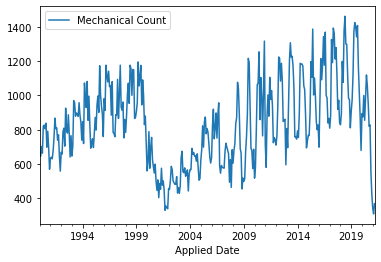

In [45]:
permit_mechanical_by_month.plot();

In [46]:
permit_electrical = spark.sql('''SELECT `Applied Date`,`Description`
                                FROM permits
                                WHERE `Permit Type` = 'EP'
                                ORDER BY 1''')
permit_electrical_df = permit_electrical.toPandas().dropna()
permit_electrical_df;

In [47]:
permit_electrical_df['Applied Date'] = pd.to_datetime(permit_electrical_df['Applied Date'])
permit_electrical_df_after_1990 = permit_electrical_df[permit_electrical_df['Applied Date'] >= datetime.datetime(1990,1,1)]

In [48]:
permit_electrical_by_month = permit_electrical_df_after_1990.groupby(permit_electrical_df_after_1990['Applied Date'].dt.to_period("M")).agg('count')
permit_electrical_by_month.index = permit_electrical_by_month.index.astype('datetime64[ns]')
permit_electrical_by_month['Electrical Count'] = permit_electrical_by_month['Applied Date']
permit_electrical_by_month = permit_electrical_by_month.drop(['Applied Date'], axis=1)
permit_electrical_by_month = permit_electrical_by_month.drop(['Description'], axis=1)
permit_electrical_by_month;

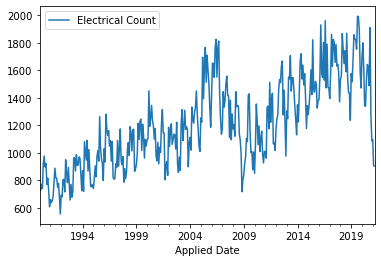

In [49]:
permit_electrical_by_month.plot();

In [50]:
permit_plumbing = spark.sql('''SELECT `Applied Date`,`Description`
                                FROM permits
                                WHERE `Permit Type` = 'PP'
                                ORDER BY 1''')
permit_plumbing_df = permit_plumbing.toPandas().dropna()
permit_plumbing_df;

In [51]:
permit_plumbing_df['Applied Date'] = pd.to_datetime(permit_plumbing_df['Applied Date'])
permit_plumbing_df_after_1990 = permit_plumbing_df[permit_plumbing_df['Applied Date'] >= datetime.datetime(1990,1,1)]

In [52]:
permit_plumbing_by_month = permit_plumbing_df_after_1990.groupby(permit_plumbing_df_after_1990['Applied Date'].dt.to_period("M")).agg('count')
permit_plumbing_by_month.index = permit_plumbing_by_month.index.astype('datetime64[ns]')
permit_plumbing_by_month['Plumbing Count'] = permit_plumbing_by_month['Applied Date']
permit_plumbing_by_month = permit_plumbing_by_month.drop(['Applied Date'], axis=1)
permit_plumbing_by_month = permit_plumbing_by_month.drop(['Description'], axis=1)
permit_plumbing_by_month;

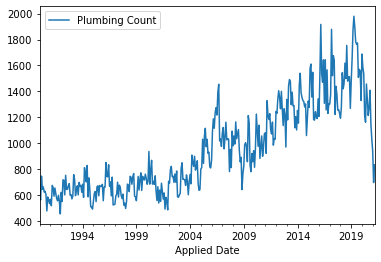

In [53]:
permit_plumbing_by_month.plot();

In [54]:
permit_building = spark.sql('''SELECT `Applied Date`,`Description`
                                FROM permits
                                WHERE `Permit Type` = 'BP'
                                ORDER BY 1''')
permit_building_df = permit_building.toPandas().dropna()
permit_building_df;

In [55]:
permit_building_df['Applied Date'] = pd.to_datetime(permit_building_df['Applied Date'])
permit_building_df_after_1990 = permit_building_df[permit_building_df['Applied Date'] >= datetime.datetime(1990,1,1)]

In [56]:
permit_building_by_month = permit_building_df_after_1990.groupby(permit_building_df_after_1990['Applied Date'].dt.to_period("M")).agg('count')
permit_building_by_month.index = permit_building_by_month.index.astype('datetime64[ns]')
permit_building_by_month['Building Count'] = permit_building_by_month['Applied Date']
permit_building_by_month = permit_building_by_month.drop(['Applied Date'], axis=1)
permit_building_by_month = permit_building_by_month.drop(['Description'], axis=1)
permit_building_by_month;

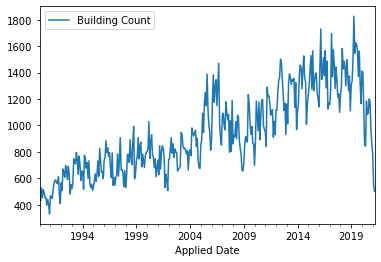

In [57]:
permit_building_by_month.plot();

In [69]:
def stationary_test(timeseries, ax):
    
    moving_average = timeseries.rolling(window=12).mean()
    moving_std = timeseries.rolling(window=12).std()
    
    ax.plot(timeseries, color='blue', label='Original Data')
    ax.plot(moving_average, color='red', label='Mean')
    ax.plot(moving_std, color='black', label='std')
    ax.legend(loc='best')
    ax.set_title('Rolling Mean and Standard Deviation')
    plt.show()
    
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value', '# Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

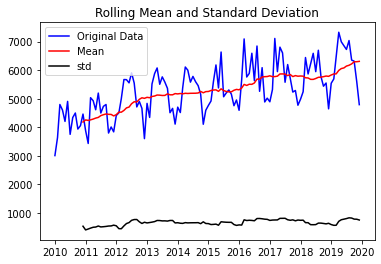

Results of Dickey Fuller Test:
Test Statistics                 -0.940087
p-value                          0.774485
# Lags Used                     11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [70]:
fig, ax = plt.subplots()
stationary_test(permit_by_month_2010_2020, ax)

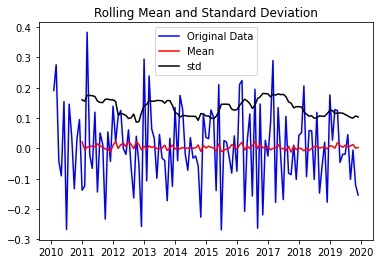

Results of Dickey Fuller Test:
Test Statistics                 -3.730220
p-value                          0.003708
# Lags Used                     13.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [108]:
permit_by_month_2010_2020_log = np.log(permit_by_month_2010_2020)
permit_by_month_2010_2020_log_shift = permit_by_month_2010_2020_log - permit_by_month_2010_2020_log.shift()
permit_by_month_2010_2020_log_shift.dropna(inplace=True)

fig, ax = plt.subplots()
stationary_test(permit_by_month_2010_2020_log_shift, ax)

In [119]:
model = ARIMA(permit_by_month_2010_2020_log, order=(2,1,2))
arima_results = model.fit(disp=-1)

Text(0.5, 1.0, 'ARIMA Model')

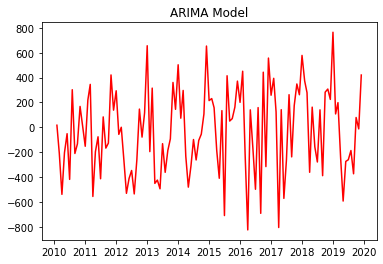

In [120]:
fig, ax = plt.subplots()
# ax.plot(permit_by_month_2010_2020_log_shift)
ax.plot(arima_results.fittedvalues, color='red')
ax.set_title('ARIMA Model')

In [121]:
predictions_arima_diff = pd.Series(arima_results.fittedvalues, copy=True)
predictions_arima_diff_cumsum = predictions_arima_diff.cumsum()
predictions_arima_diff_cumsum

Applied Date
2010-02-01      16.823400
2010-03-01    -191.434548
2010-04-01    -730.596822
2010-05-01    -935.369389
2010-06-01    -986.635781
                 ...     
2019-08-01   -3956.677857
2019-09-01   -4330.429129
2019-10-01   -4251.428907
2019-11-01   -4264.203913
2019-12-01   -3843.705031
Freq: MS, Length: 119, dtype: float64

In [123]:
predictions_arima_log = pd.Series(permit_by_month_2010_2020_log.iloc[0], index=permit_by_month_2010_2020_log.index)
predictions_arima_log = predictions_arima_log.add(predictions_arima_diff_cumsum, fill_value=0)
predictions_arima = np.exp(predictions_arima_log)
predictions_arima

Applied Date
2010-01-01              NaN
2010-02-01     2.024462e+07
2010-03-01     7.261598e-84
2010-04-01    5.079627e-318
2010-05-01     0.000000e+00
                  ...      
2019-08-01     0.000000e+00
2019-09-01     0.000000e+00
2019-10-01     0.000000e+00
2019-11-01     0.000000e+00
2019-12-01     0.000000e+00
Freq: MS, Length: 120, dtype: float64